In [1]:
from sympy import Symbol, symbols, Derivative
import sympy as sp
import numpy as np
sp.init_printing(use_unicode=True)
sp.init_session(quiet=True)
from scipy.signal import find_peaks
%matplotlib inline

### sympy bit

In [2]:
t1, t2, t3, r1, r2, r3 = symbols("t1 t2 t3 r1 r2 r3")
L1, L2, delta_L1, delta_L2 = symbols("L1 L2 delta_L1 delta_L2")
k = Symbol("k")

In [3]:
# create the formula

mirror_matrices = []

transmissivity = [t1, t2, t3]
reflectivity = [r1, r2, r3]

for (t, r) in zip(transmissivity, reflectivity):
    M = (1 / (1j * t)) * Matrix([[-1, -r], [r, 1]])
    mirror_matrices.append(M)

propagation_matrices = []

L = [L1, L2]
delta = [delta_L1, delta_L2]

for (L, delta) in zip(L, delta):
    M = Matrix([[sp.exp(1j * k * (L + delta)), 0], [0, sp.exp(-1j * k * (L + delta))]])
    propagation_matrices.append(M)

transfer_matrix = mirror_matrices[2]*propagation_matrices[1]*mirror_matrices[1]*propagation_matrices[0]*mirror_matrices[0]


reflection_coeff = -transfer_matrix[1, 0] / transfer_matrix[1, 1]
transmission_coeff = (transfer_matrix[0, 0]*transfer_matrix[1, 1] - transfer_matrix[0, 1]*transfer_matrix[1, 0]) / transfer_matrix[1, 1]

transmitted_power = sp.Abs(transmission_coeff)**2
reflect_power = sp.Abs(reflection_coeff) ** 2

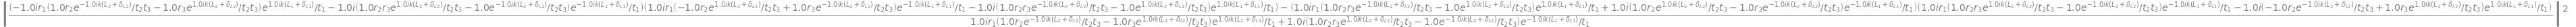

In [4]:
transmitted_power

#### variables

In [ ]:
mirror_1 = Mirror(0.1)
mirror_2 = Mirror(0.1)
mirror_3 = Mirror(0.1) # cant set to zero since at some point its in a denominator, at <-11 it goes a bit crazy

wavelength = 1064e-9 
c = 3e8

def dynamic_range(L1, L2, d1, d2, order = 3.76e6):
    fsr = c / (2 * (L1 + L2 - d1 + d2))
    resonance_nu = order*fsr 
    nu_bottom = resonance_nu - 75e6
    nu_top = resonance_nu + 75e6
    nu_sweep = np.linspace(nu_bottom, nu_top, 10000)
    k_range = nu_sweep * 2 * np.pi /c
    return k_range, nu_sweep

def peak_data(transmission, peak_position_1, peak_position_2, delta_nu):
    peaks, properties = find_peaks(transmission)
    print(peaks)
    peak_freq = delta_nu[peaks] * 1e-6
    peak_position_1.append(peak_freq[0])
    peak_position_2.append(peak_freq[1])
    return peak_position_1, peak_position_2

In [40]:
nu_sweep
#k_range.min() 

array([2.81999912e+14, 2.81999912e+14, 2.81999912e+14, ...,
       2.82000062e+14, 2.82000062e+14, 2.82000062e+14])

#### plotting transmission vs freq

[4494 5505]
[2147 4092]
[5907 7852]


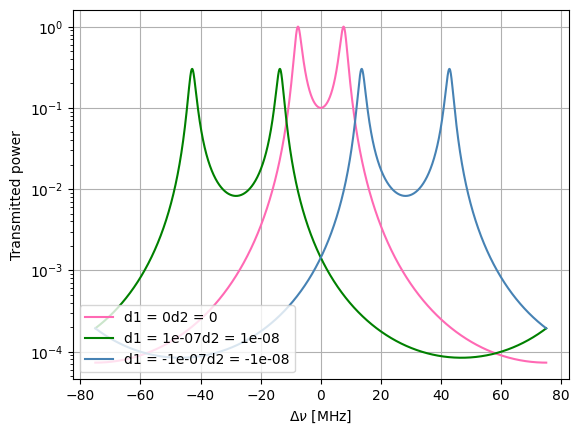

In [25]:
delta_L1_arr = [0, 100e-9, -100e-9]
delta_L2_arr = [0, 10e-9, -10e-9]
L1_arr = [1, 1, 1]
L2_arr  = [1, 1, 1]
delta_nu = np.linspace(-75e6, 75e6, 10000)
cavity = Cavity(L1_arr, delta_L1_arr, L2_arr, delta_L2_arr)
colors = ["hotpink", "green", "steelblue"]

peak_separation = []
peak_position_1 = [] 
peak_position_2 = []

transmitted_power_numeric = transmitted_power.subs([(t1, mirror_1.t), (t2, mirror_2.t), (t3, mirror_3.t), (r1, mirror_1.r), (r2, mirror_2.r), (r3, mirror_3.r)])
transmitted_power_function = lambdify((k, L1, L2, delta_L1, delta_L2), transmitted_power_numeric, "numpy")

for (l1, l2, d1, d2, color) in zip(cavity.subcavity_1.L, cavity.subcavity_2.L , cavity.subcavity_1.delta, cavity.subcavity_2.delta, colors):

    k_range, nu_sweep = dynamic_range(l1, l2, d1, d2)
    transmission = transmitted_power_function(k_range, l1, l2, d1, d2)

    peak_position_1, peak_position_2 = peak_data(transmission, peak_position_1, peak_position_2, delta_nu)


    plt.plot(delta_nu * 1e-6, transmission, label = "d1 = " + str(d1) + "d2 = " + str(d2), c = color)


plt.grid()
plt.yscale("log")
plt.legend(loc = "lower left")
plt.ylabel("Transmitted power")
plt.xlabel(r"$\Delta \nu$ [MHz]")
plt.show()

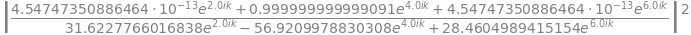

In [28]:
transmitted_power_numeric = transmitted_power_numeric.subs([(t1, mirror_1.t), (t2, mirror_2.t), (t3, mirror_3.t), (r1, mirror_1.r), (r2, mirror_2.r), (r3, mirror_3.r), (L1, 1), (L2, 1), (delta_L1, 0), (delta_L2, 0)])
transmitted_power_numeric.simplify()

In [29]:
transfer_matrix

⎡           ⎛          1.0⋅ⅈ⋅k⋅(L₂ + δ_L2)           -1.0⋅ⅈ⋅k⋅(L₂ + δ_L2)⎞     ↪
⎢           ⎜  1.0⋅r₂⋅ℯ                      1.0⋅r₃⋅ℯ                    ⎟  -1 ↪
⎢  1.0⋅ⅈ⋅r₁⋅⎜- ─────────────────────────── + ────────────────────────────⎟⋅ℯ   ↪
⎢           ⎝             t₂⋅t₃                         t₂⋅t₃            ⎠     ↪
⎢- ─────────────────────────────────────────────────────────────────────────── ↪
⎢                                               t₁                             ↪
⎢                                                                              ↪
⎢           ⎛           1.0⋅ⅈ⋅k⋅(L₂ + δ_L2)        -1.0⋅ⅈ⋅k⋅(L₂ + δ_L2)⎞       ↪
⎢           ⎜1.0⋅r₂⋅r₃⋅ℯ                      1.0⋅ℯ                    ⎟  -1.0 ↪
⎢  1.0⋅ⅈ⋅r₁⋅⎜────────────────────────────── - ─────────────────────────⎟⋅ℯ     ↪
⎢           ⎝            t₂⋅t₃                          t₂⋅t₃          ⎠       ↪
⎢- ─────────────────────────────────────────────────────────────────────────── ↪
⎣                           

#### phase response

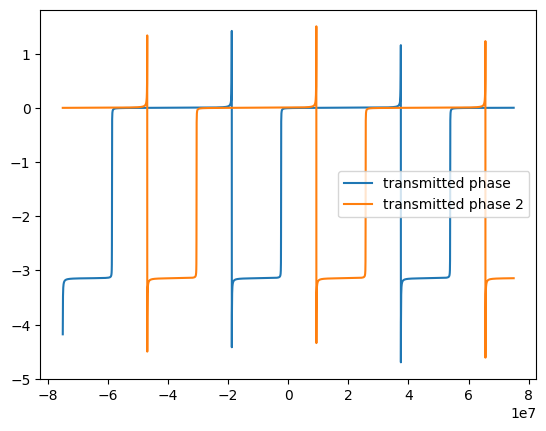

In [ ]:
transmission_coeff_numeric = transmission_coeff.subs([(t1, mirror_1.t), (t2, mirror_2.t), (t3, mirror_3.t), (r1, mirror_1.r), (r2, mirror_2.r), (r3, mirror_3.r)])
transmission_coeff_function =  lambdify((k, L1, L2, delta_L1, delta_L2), transmission_coeff_numeric, "numpy")

reflection_coeff_numeric = reflection_coeff.subs([(t1, mirror_1.t), (t2, mirror_2.t), (t3, mirror_3.t), (r1, mirror_1.r), (r2, mirror_2.r), (r3, mirror_3.r)])
reflection_coeff_function =  lambdify((k, L1, L2, delta_L1, delta_L2), reflection_coeff_numeric, "numpy")

def dynamic_range(L1, L2, d1, d2, order = 3.76e6):

    fsr = c / (2 * (L1 + L2 - d1 + d2))
    resonance_nu = order*fsr # removed the order because idk at some point could be nice to make a search thingy to find the order
    nu_bottom = resonance_nu - 200e6
    nu_top = resonance_nu + 200e6
    nu_sweep = np.linspace(nu_bottom, nu_top, 10000)
    k_range = nu_sweep * 2 * np.pi /c
    return k_range, nu_sweep

k_range_1, nu_range_1 = dynamic_range(cavity.subcavity_1.L[0], cavity.subcavity_2.L[0], cavity.subcavity_1.delta[1], cavity.subcavity_2.delta[1])
k_range_2, nu_range_2 = dynamic_range(cavity.subcavity_1.L[0], cavity.subcavity_2.L[0], cavity.subcavity_1.delta[1], cavity.subcavity_2.delta[1], 3.76e6+1)

# p 86-87 vincent dumont thesis

phase_ref = np.angle(reflection_coeff_function(k_range_1, cavity.subcavity_1.L[0], cavity.subcavity_2.L[0], cavity.subcavity_1.delta[1], cavity.subcavity_2.delta[1]))
phase_trans = np.angle(transmission_coeff_function(k_range_1, cavity.subcavity_1.L[0], cavity.subcavity_2.L[0], cavity.subcavity_1.delta[1], cavity.subcavity_2.delta[1]))
    

# plt.plot(delta_nu, phase_ref, label = "reflected phase")
plt.plot(delta_nu, phase_trans - np.pi /2, label = "transmitted phase")

phase_ref_bis = np.angle(reflection_coeff_function(k_range_2, cavity.subcavity_1.L[0], cavity.subcavity_2.L[0], cavity.subcavity_1.delta[1], cavity.subcavity_2.delta[1]))
phase_trans_bis = np.angle(transmission_coeff_function(k_range_2, cavity.subcavity_1.L[0], cavity.subcavity_2.L[0], cavity.subcavity_1.delta[1], cavity.subcavity_2.delta[1]))


# plt.plot(delta_nu, phase_ref_bis, label = "reflected phase 2")
plt.plot(delta_nu, phase_trans_bis - np.pi /2, label = "transmitted phase 2")

plt.legend()
plt.show()

#### solving for the resonance position

In [192]:
# solve for d transmitted power / d k = 0

# i am genuienly unable to a) spell and b) solve this using sympy it seems

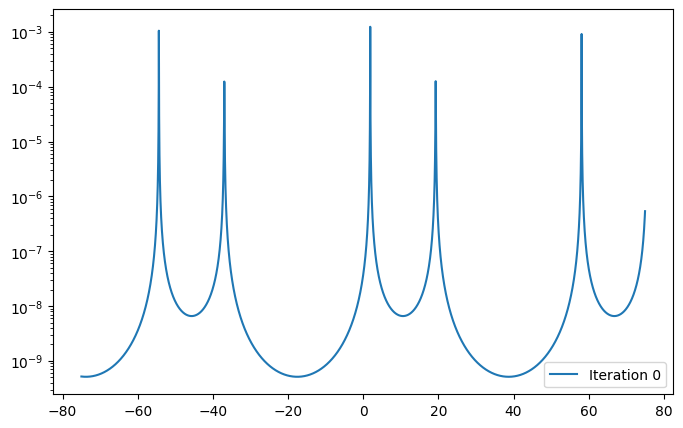

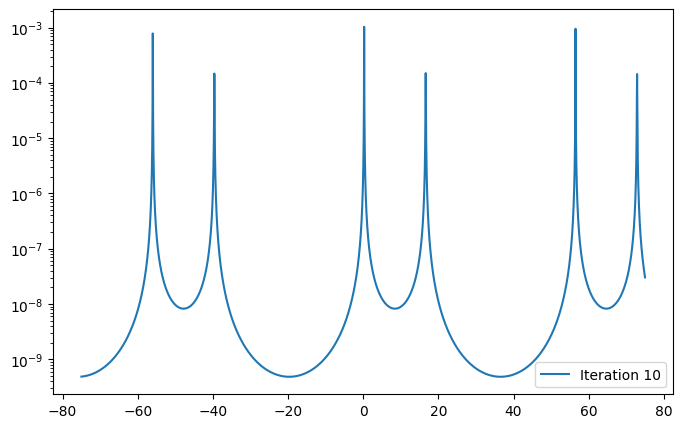

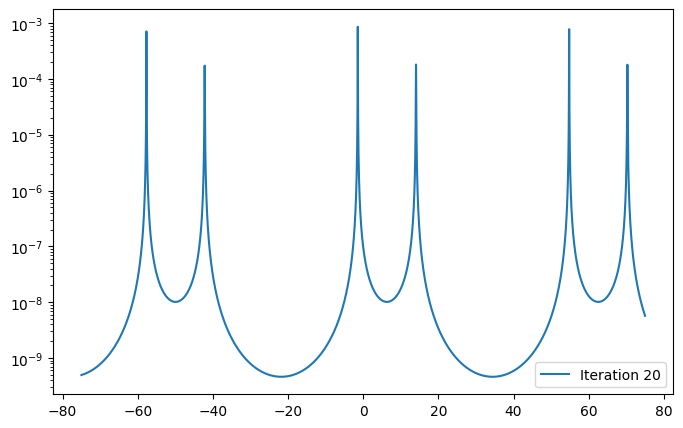

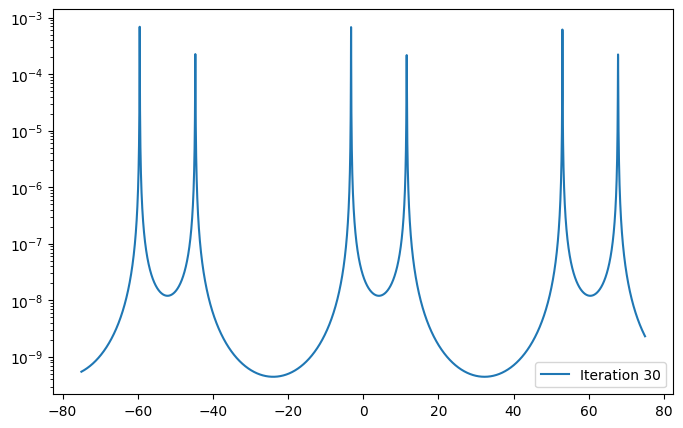

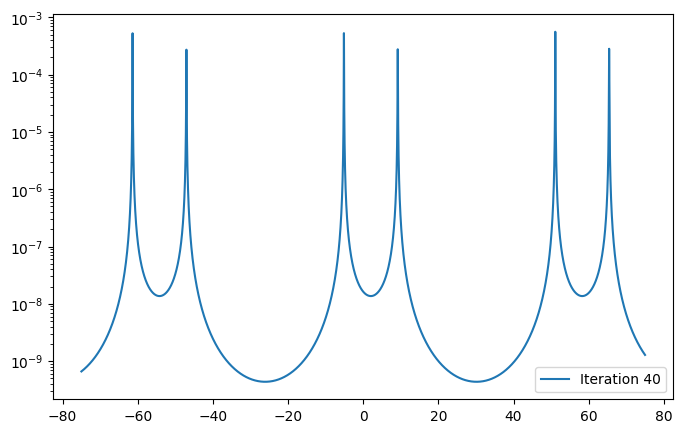

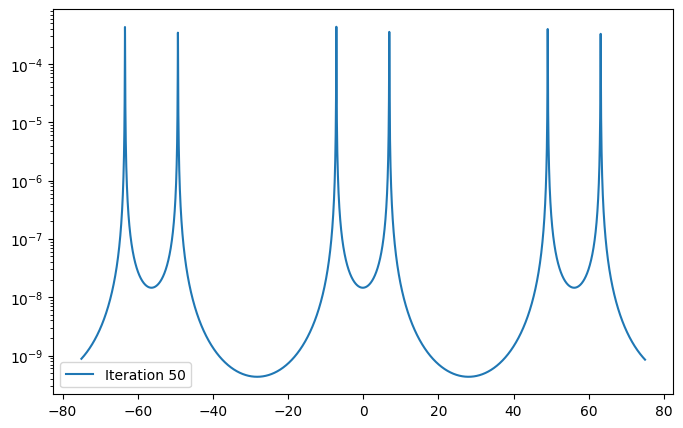

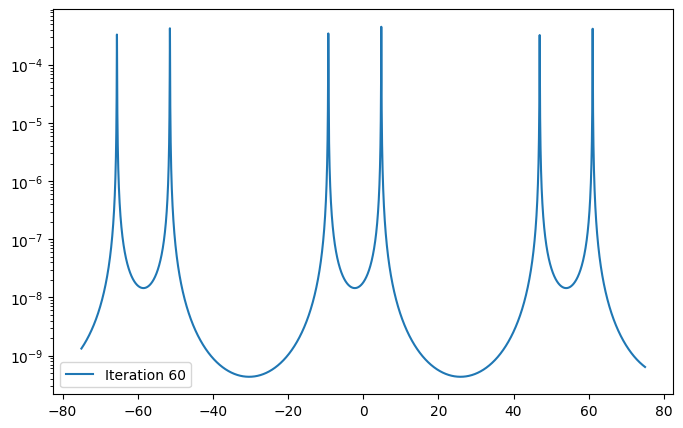

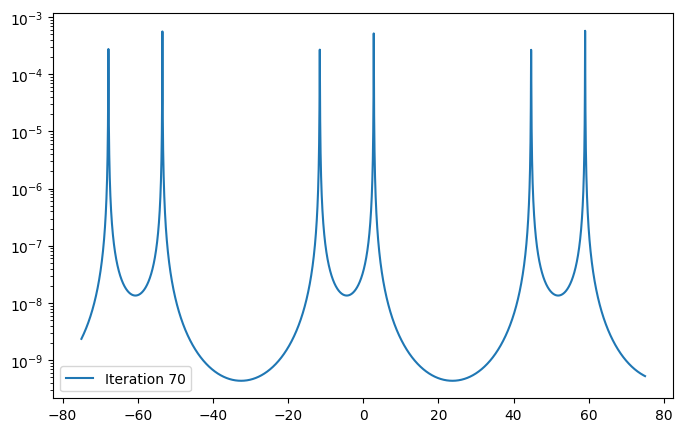

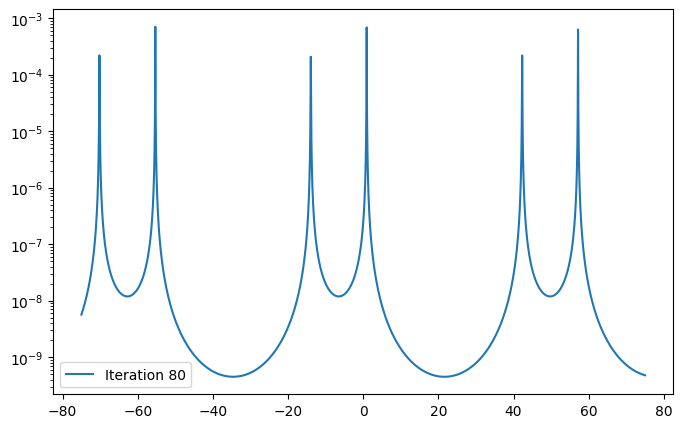

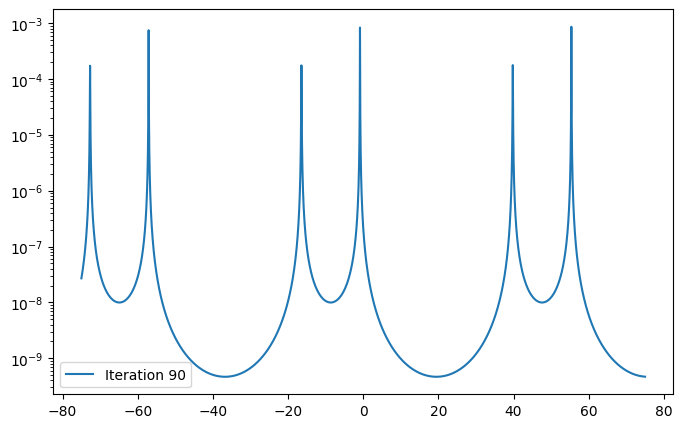

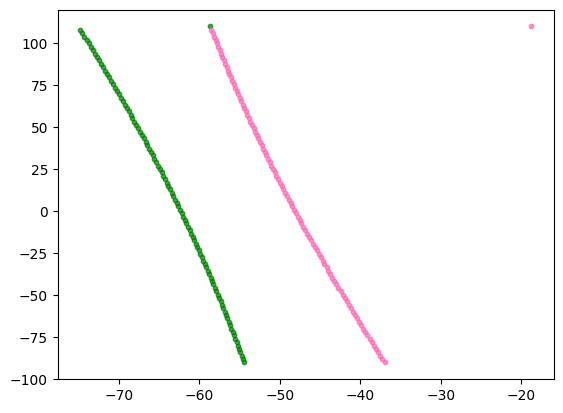

In [262]:
delta_L1_arr = np.linspace(-100e-9, 100e-9, 100)
delta_L2_arr = np.linspace(10e-9, 10e-9, 100)
L1_arr = np.linspace(1, 1, 100)
L2_arr = np.linspace(1, 1, 100)
delta_nu = np.linspace(-75e6, 75e6, 10000)
colors = ["hotpink", "green", "steelblue"]
peak_separation = []
res_omega = []
peak_pos = []
L_plus = []

cavity = Cavity(L1_arr, delta_L1_arr, L2_arr, delta_L2_arr)
colors = ["hotpink", "green", "steelblue"]

peak_position_1 = [] 
peak_position_2 = []
L_plus = []

transmitted_power_numeric = transmitted_power.subs([(t1, mirror_1.t), (t2, mirror_2.t), (t3, mirror_3.t), (r1, mirror_1.r), (r2, mirror_2.r), (r3, mirror_3.r)])
transmitted_power_function = lambdify((k, L1, L2, delta_L1, delta_L2), transmitted_power_numeric, "numpy")

# for (l1, l2, d1, d2) in zip(cavity.subcavity_1.L, cavity.subcavity_2.L , cavity.subcavity_1.delta, cavity.subcavity_2.delta):

    # k_range, nu_sweep = dynamic_range(l1, l2, d1, d2)
    # transmission = transmitted_power_function(k_range, l1, l2, d1, d2)

    # peaks, properties = find_peaks(transmission)
    # peak_freqs_mhz = delta_nu[peaks] * 1e-6
    # peak_position_1.append(peak_freqs_mhz[0])
    # peak_position_2.append(peak_freqs_mhz[1])

    # L_plus.append( (d1 + d2)*1e9)

for i, (l1, l2, d1, d2) in enumerate(zip(cavity.subcavity_1.L, cavity.subcavity_2.L, 
                                          cavity.subcavity_1.delta, cavity.subcavity_2.delta)):

    k_range, nu_sweep = dynamic_range(l1, l2, d1, d2)
    transmission = transmitted_power_function(k_range, l1, l2, d1, d2)

    peaks, _ = find_peaks(transmission, height = 10e-5)
    
    
    peak_freqs_mhz = delta_nu[peaks] * 1e-6  # Convert to MHz
    peak_position_1.append(peak_freqs_mhz[0])
    peak_position_2.append(peak_freqs_mhz[1])

    L_plus.append((d1 + d2) * 1e9)

    # plot some iterations
    if i % 10 == 0:
        plt.figure(figsize=(8, 5))
        plt.plot(delta_nu * 1e-6, transmission, label=f"Iteration {i}")  # Convert delta_nu to MHz
        plt.legend()
        plt.yscale("log")
        plt.show()


plt.scatter(peak_position_1, L_plus, c = "green", s = 10, alpha= 0.7)
plt.scatter(peak_position_2, L_plus, c = "hotpink", s = 10, alpha = 0.7)


In [263]:
def resonances(L1, L2, d1, d2, delta_nu, transmission, height = 10e-5):
    """
    change height if necessary
    """
    peaks, _ = find_peaks(transmission, height = height)
    peak_freqs_mhz = delta_nu[peaks] * 1e-6  # Convert to MHz
    peak_position_1 = peak_freqs_mhz[0]
    peak_position_2 = peak_freqs_mhz[1]
    return peak_position_1, peak_position_2


#### ok yay now the find peaks works and i know the resonances numerically, so i can come back to my phase response graphs and recenter them

In [264]:
p1, p2 = resonances(cavity.subcavity_1.L[0], cavity.subcavity_2.L[0], cavity.subcavity_1.delta[1], cavity.subcavity_2.delta[1], delta_nu, transmitted_power_function(k_range_1, cavity.subcavity_1.L[0], cavity.subcavity_2.L[0], cavity.subcavity_1.delta[1], cavity.subcavity_2.delta[1]))

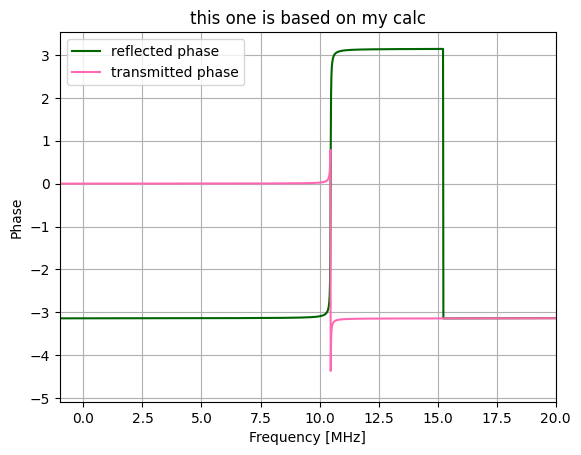

In [271]:
k_range_1, nu_range_1 = dynamic_range(cavity.subcavity_1.L[0], cavity.subcavity_2.L[0], cavity.subcavity_1.delta[1], cavity.subcavity_2.delta[1])
k_range_2, nu_range_2 = dynamic_range(cavity.subcavity_1.L[0], cavity.subcavity_2.L[0], cavity.subcavity_1.delta[1], cavity.subcavity_2.delta[1], 3.76e6+1)

# p 86-87 vincent dumont thesis

phase_ref = np.angle(reflection_coeff_function(k_range_1, cavity.subcavity_1.L[0], cavity.subcavity_2.L[0], cavity.subcavity_1.delta[1], cavity.subcavity_2.delta[1]))
phase_trans = np.angle(transmission_coeff_function(k_range_1, cavity.subcavity_1.L[0], cavity.subcavity_2.L[0], cavity.subcavity_1.delta[1], cavity.subcavity_2.delta[1]))
    

plt.plot(delta_nu * 1e-6 - p1, phase_ref, label = "reflected phase", c = "darkgreen")
plt.plot(delta_nu * 1e-6 - p1, phase_trans - np.pi /2, label = "transmitted phase", c = "hotpink")

# phase_ref_bis = np.angle(reflection_coeff_function(k_range_2, cavity.subcavity_1.L[0], cavity.subcavity_2.L[0], cavity.subcavity_1.delta[1], cavity.subcavity_2.delta[1]))
# phase_trans_bis = np.angle(transmission_coeff_function(k_range_2, cavity.subcavity_1.L[0], cavity.subcavity_2.L[0], cavity.subcavity_1.delta[1], cavity.subcavity_2.delta[1]))
 

# plt.plot(delta_nu, phase_ref_bis, label = "reflected phase 2")
# plt.plot(delta_nu, phase_trans_bis - np.pi /2, label = "transmitted phase 2")
plt.xlim([-1, 20])
plt.grid()
plt.ylabel("Phase")
plt.xlabel("Frequency [MHz]")
plt.title("this one is based on my calc")
plt.legend()
# plt.xlim([10.40, 11])
plt.show()

#### compare with the theoretical phase response thingy from pe

In [73]:
omega = Symbol("omega")
mir_1_t = Symbol("mir_1_t")

gamma = c * mir_1_t / (4 * cavity.total_length[0])


Lambda = 0 # for now lossless

omega = Symbol("omega")
cavity_detuning = 20e6 

nominator = 2 * gamma * (omega - cavity_detuning)
denominator = - gamma **2 + (omega - cavity_detuning) **2

alpha_fc = sp.atan(nominator / denominator)

alpha_fc_function = lambdify((omega, mir_1_t), alpha_fc)

def alpha_p(omega, t):
    return (alpha_fc_function(omega, t) + alpha_fc_function(- omega, t)) / 2

In [59]:
# indeed if the detuning is zero the alpha_p value is always zero


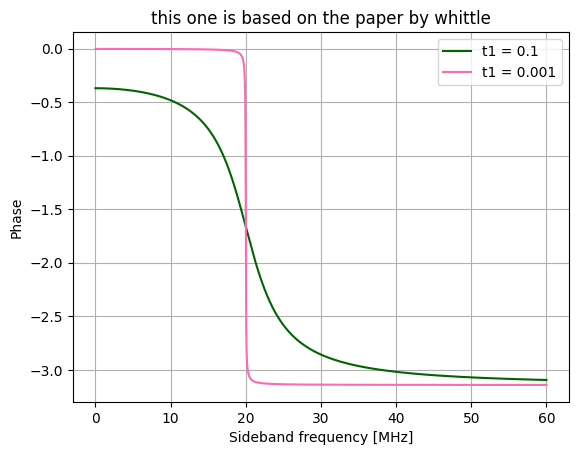

In [159]:
omega_arr = np.linspace(0, 60e6, 50000)
# alpha_fc_arr = alpha_fc_function(omega_arr)
mir_1_t_arr = [mirror_1.t, 0.001]
colors = ["darkgreen", "hotpink"]
for (t, color) in zip(mir_1_t_arr, colors):
    # alpha_fc_arr_1 = alpha_fc_function(omega_arr, t)
    # alpha_fc_arr_2 = alpha_fc_function(-omega_arr, t)
    alpha_p_arr = alpha_p(omega_arr, t)
    plt.plot(omega_arr * 1e-6, np.unwrap(alpha_p_arr, period = np.pi/4, axis = 0), c = color, label = "t1 = " + str(t))

    #  plt.plot(omega_arr * 1e-6, np.unwrap(alpha_p_arr+np))


plt.grid()
plt.title("this one is based on the paper by whittle")
plt.ylabel("Phase")
plt.xlabel("Sideband frequency [MHz]")
plt.legend()
# plt.xlim([-21, -19])
plt.show()


# phase ranges by pi instead of two pi as above - something wrong with my sp.atan?

- if sp.arg is used the phase range is $\pi/2$ 
    - supposed to give an angle between $-\pi, \pi$
- if sp.atan - some random bullshit
    - supposed to give an angle between $-\pi/2, \pi/2$

In [ ]:
omega_laser, m, omega, P, omega_m, damping, chi = symbols("omega_laser m omega P omega_m damping chi")

P = 20
m = 42
F = 1
L = 3e3
fsrOM = c/2*L
# kappaOM = fsrOM/F
kappaOM = 113
omega_m = 2
damping = 100e-3

chi = ( m * (omega_m ** 2 - omega ** 2 + I * damping * omega)) ** (-1)

omega_laser = 2 * np.pi * c / wavelength
K = sp.atan((16 * omega_laser * P) / (c * L * kappaOM) * chi)
K_func = lambdify(omega, K)

# kappa = linewidth of the cavity

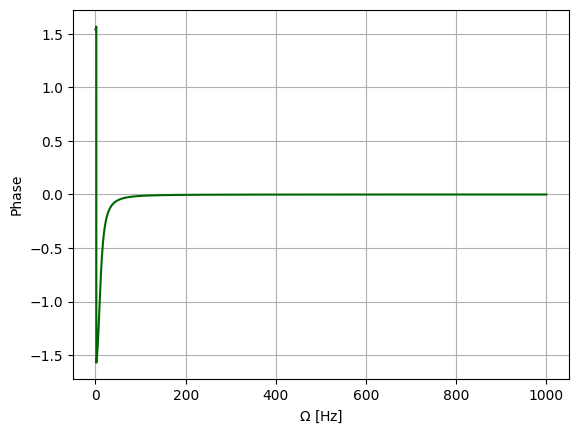

In [250]:
omega_arr = np.linspace(0, 1e3, 10000)
plt.plot(omega_arr, K_func(omega_arr), c = "darkgreen")
plt.grid()
plt.xlabel(r"$\Omega$ [Hz]")
plt.ylabel("Phase")
plt.show()